In [104]:
# data from: https://www.kaggle.com/datasets/bahadoreizadkhah/face-mask-types-dataset/code
# reference: https://towardsdatascience.com/from-alexnet-to-nasnet-a-brief-history-and-introduction-of-convolutional-neural-networks-cf63bf3320e1 
# reference: https://github.com/Alexiush/weak-causality-and-causal-disposition-in-images/blob/main/ca_cnn_sample_resnet.ipynb

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix
import pathlib

In [105]:
data_train = pathlib.Path('./Dataset/train')
data_test = pathlib.Path('./Dataset/test')

INPUT_SIZE = [300, 300]
BATCH = 6

In [106]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.0,
    # rescale=1./255,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
    )

training_data = training_datagen.flow_from_directory('./Dataset/train', 
                                                     subset="training", 
                                                     shuffle=True, 
                                                     target_size=INPUT_SIZE, 
                                                     batch_size=BATCH, 
                                                     color_mode="rgb",
                                                     class_mode='categorical')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

test_data = test_datagen.flow_from_directory('./Dataset/test', 
                                             target_size=INPUT_SIZE, 
                                             color_mode="rgb", 
                                             batch_size=BATCH,
                                             class_mode='categorical',
                                             shuffle=False)

# display dimensions
x_test, y_test = next(test_data)
x_train, y_train = next(training_data)

Found 1956 images belonging to 5 classes.
Found 330 images belonging to 5 classes.


In [107]:
# pooling='avg' => same as adding GlobalAveragePooling2D 
resn_model = tf.keras.applications.ResNet101V2(input_shape=(300, 300,3), include_top=False, weights='imagenet')
resn_model.trainable = True

fine_tune_at = 100
for layer in resn_model.layers[:fine_tune_at]:
    layer.trainable = False

# resn_model.summary()

In [108]:
import tensorflow as tf

# tf.keras.utils.plot_model(resn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [109]:
import visualkeras

# visualkeras.layered_view(resn_model)

In [124]:
model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
    tf.keras.layers.InputLayer((300, 300, 3)),
    resn_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(300, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    Dense(300, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    Dense(5, activation='softmax')])

# model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
#     tf.keras.layers.InputLayer((300, 300, 3)),
#     resn_model,
#     tf.keras.layers.AveragePooling2D(pool_size = (4,4), padding='same'),
#     Flatten(),
#     Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     Dense(5, activation='softmax')])
# 
# model.summary()

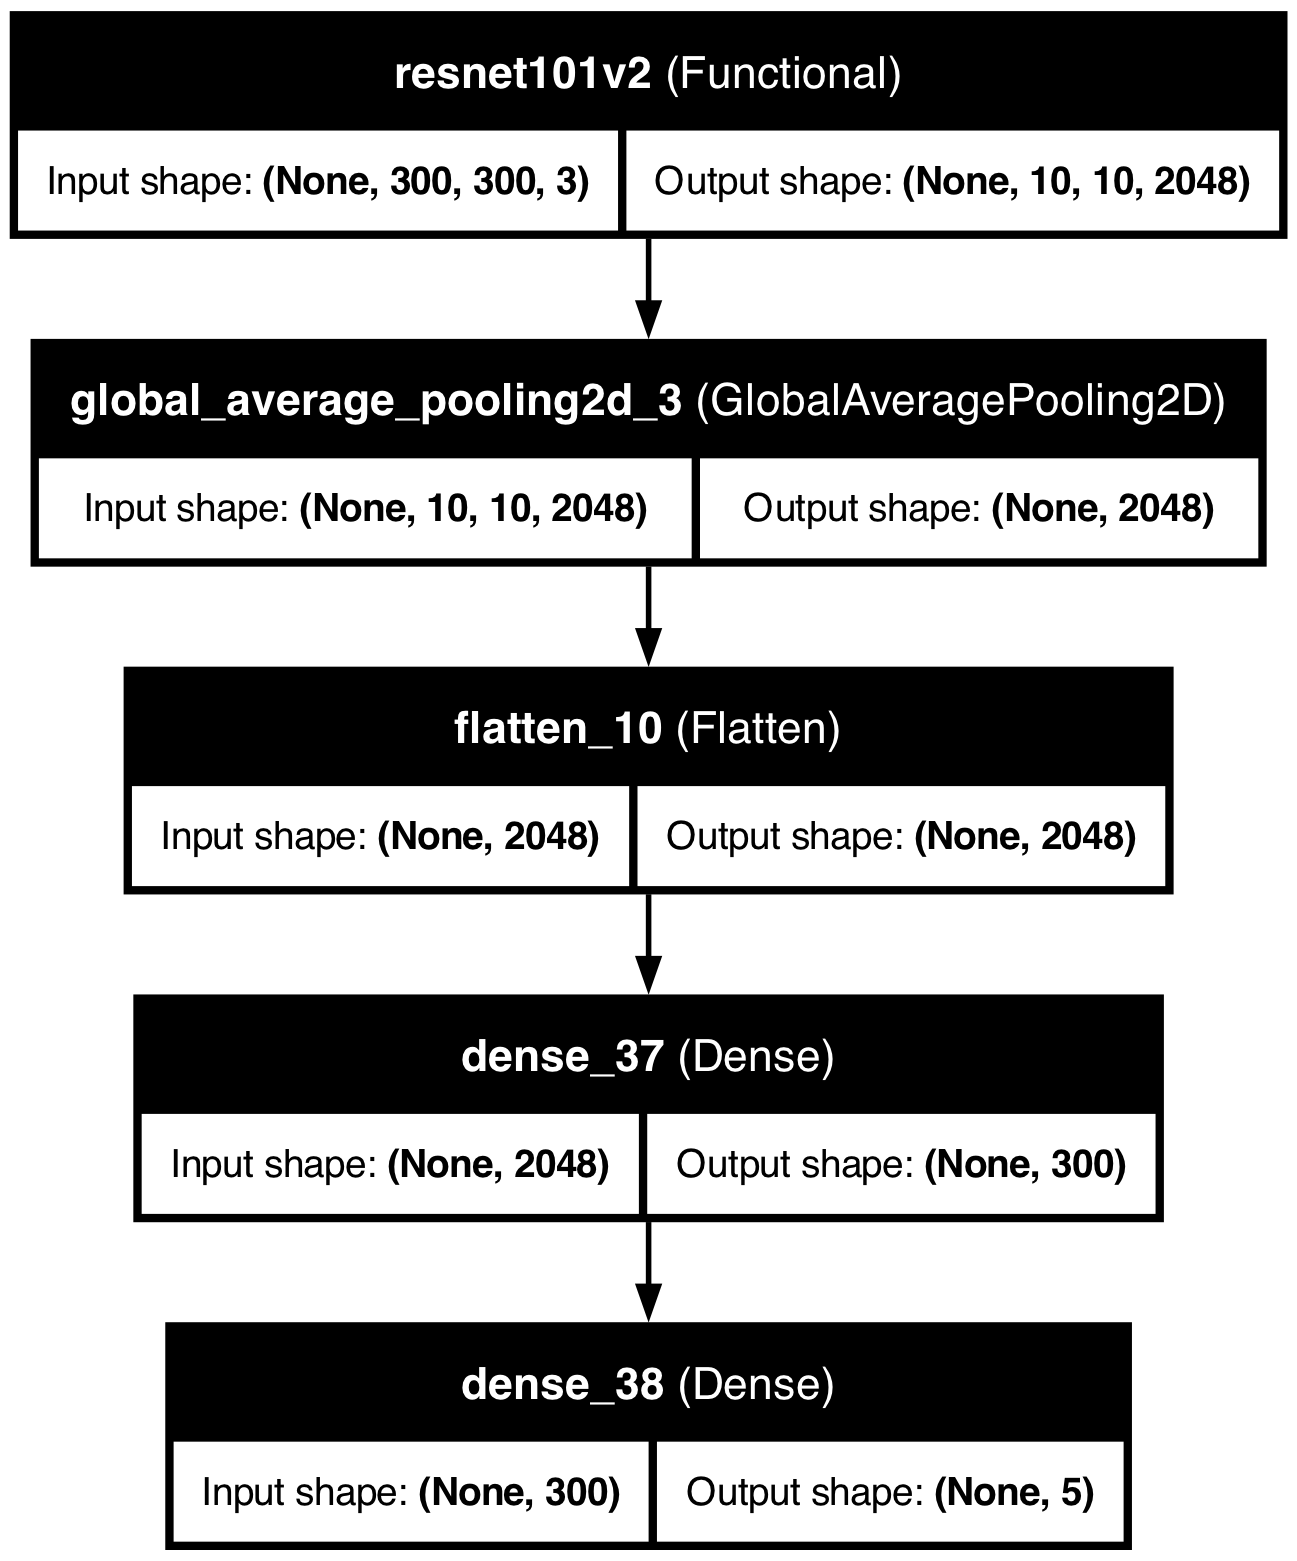

In [111]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

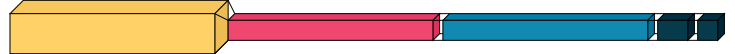

In [112]:
visualkeras.layered_view(model)

In [125]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)
#  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)

history = model.fit(
    training_data,
    validation_data=test_data,
    # x=x_train,
    # y=y_train,
    # validation_split=0.2,
    epochs=5,
    # batch_size=BATCH,
    # steps_per_epoch=len(training_data),
    # validation_steps=len(test_data)
)


# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                               mode='min',
#                               verbose=1,
#                               patience=25
#                               )
# checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/tmp/classifier-resnet-weights.hdf5",
#                                verbose=1,
#                                save_best_only=True
#                                )
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                               mode='min',
#                               verbose=1,
#                               patience=10,
#                               min_delta=0.0001,
#                               factor=0.2
#                               )

# callbacks = [checkpointer, earlystopping, reduce_lr]

# history = model.fit(training_data,
#                     steps_per_epoch= training_data.n // training_data.batch_size,
#                     epochs = 5,
#                     validation_data= test_data,
#                     validation_steps= test_data.n // test_data.batch_size,
#                     callbacks = [earlystopping, reduce_lr]
#                     )

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.6557 - loss: 0.9285 - val_accuracy: 0.8000 - val_loss: 0.5517
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.7755 - loss: 0.6213 - val_accuracy: 0.8333 - val_loss: 0.4453
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.8245 - loss: 0.4959 - val_accuracy: 0.7242 - val_loss: 1.1531
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.8140 - loss: 0.5365 - val_accuracy: 0.8667 - val_loss: 0.4114
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.8593 - loss: 0.4136 - val_accuracy: 0.8242 - val_loss: 0.7525


In [126]:
# create confusion matrix
y_pred=model.predict(test_data, batch_size=BATCH)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm=confusion_matrix(test_data.classes, y_pred)
print(cm)

#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)

loss, accuracy = model.evaluate(test_data, verbose=0)
print(loss, accuracy)

55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 574ms/step
(330, 5)
[0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 1 0 0 1 0 1 1 0 0 1 1 0 2 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 2 1 1 1
 0 2 1 1 1 0 1 1 0 1 1 1 2 1 2 1 1 2 0 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 4 2 0 3 0 3 3 3 3 3
 2 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 0 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 3 3 3 3 3 3 3 3 0 3 0 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 0
 4 4 4 0 4 4 4 0 0 0 0 4 4 4 4 0 4 4 0 0 4 4 4 4 0 0 0 4 4 4 1 4 4 0 4 4 4
 4 4 0 4 4 4 4 4 4 4 4 4 0 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[[73  1  2  0  2]
 [14 31  5  0  0]
 [ 2  4 42  0  1]
 [ 8  0  2 68  0]
 [16  1  0  0 58]]
[0.93589744 0.62       0.85714286 0.87179487 0.77333333]
0.7524998784065247 0.8242424130439758


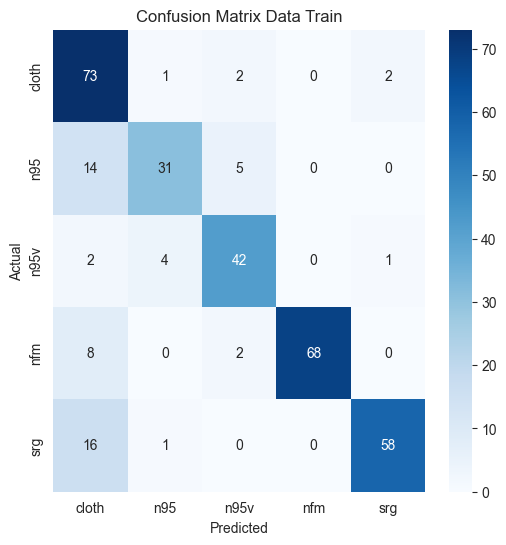

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['cloth', 'n95', 'n95v', 'nfm', 'srg'], yticklabels=['cloth', 'n95', 'n95v', 'nfm', 'srg'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Train')
plt.show()

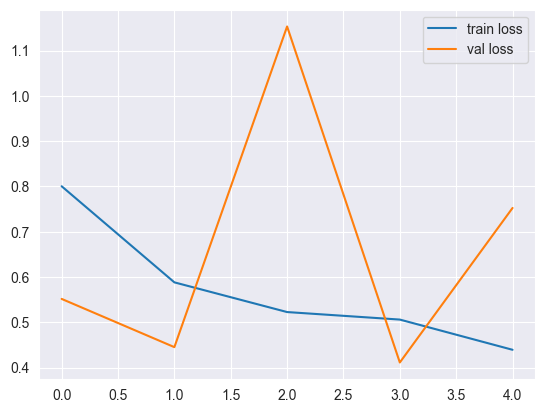

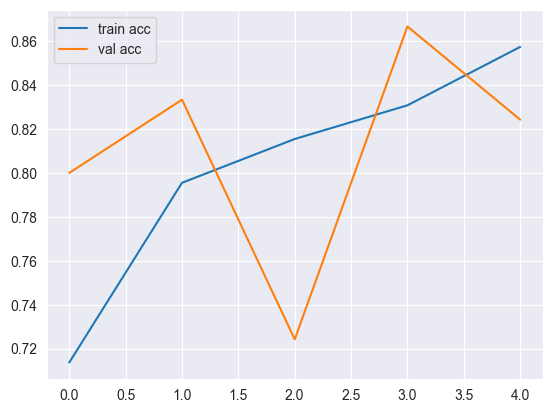

In [129]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

In [117]:
import numpy as np

test_image = tf.keras.preprocessing.image.load_img(
    './Dataset/test/cloth/1.jpg',
    target_size=INPUT_SIZE)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
i = np.argmax(result[0])
classes = training_data.class_indices.keys()
print(classes)
list(classes)[i]

# if result[0][0] < 0.5:
#     print('Image classified as WithMAsk')
# else:
#     print('Image classified as Without Mask')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


'n95v'

In [118]:
def plot_image(j, predictions_array, true_label, img):
    true_label, img = true_label[j], img[j]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                         100*np.max(predictions_array),
                                         classes[np.argmax(true_label)]),
               color=color)

def plot_value_array(k, predictions_array, true_label):
    true_label = true_label[k]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.argmax(true_label)].set_color('blue')

i = 1
print(classes)
print(classes[i])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, result, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, result[0], y_test)
plt.show()

dict_keys(['cloth', 'n95', 'n95v', 'nfm', 'srg'])


TypeError: 'dict_keys' object is not subscriptable